In [ ]:
from utils import hg_from_data, seed_everything
import random

publisher = 'OYC'
X, labels, relations, data_masks = hg_from_data(publisher)
cv = data_masks['cv']

In [ ]:
#epochs_gnn_all = [100] 
epochs_gnn_all = [100, 200, 300, 500]
epochs_clf_all = [100] #[50, 100, 300, 500]
learning_rates_all = [1e-3] #[0.001, 0.01]
#lambda_smoothing_all = [0.01, 0.1, 0.5, 0.8]
lambda_smoothing_all = [0.1]
#dropnode_rates_all = [0.0, 0.01, 0.1, 0.2, 0.5, 0.8]
#dropedge_rates_all = [0.0, 0.01, 0.1, 0.2, 0.5, 0.8]
#drophyperedge_rates_all = [0.0, 0.01, 0.1, 0.2, 0.5, 0.8]

drop_method = 'dropnode' # dropedge, dropnode or drophyperedge

drop_rates = [0.0, 0.01, 0.1, 0.2, 0.5, 0.8]


selected_params = [{
    'epochs_gnn': epochs_gnn, 
    'epochs_clf': epochs_clf,
    'learning_rate' : learning_rate,
    'lambda_smoothing': lambda_smoothing,
    'drop_rate' : drop_rate
} for epochs_gnn in epochs_gnn_all 
for epochs_clf in epochs_clf_all
for learning_rate in learning_rates_all
for lambda_smoothing in lambda_smoothing_all
for drop_rate in drop_rates]

print(len(selected_params))

24


In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score
from utils import hg_for_cv, dropout_hgnn
from random import random
from dhg import Hypergraph
import pandas as pd
import torch 


df_results = pd.DataFrame()
MLP_architecture = (512, 256, 128, 64)
optimizer = 'adam'

total_runs = len(selected_params)
current_run = 0

seed_everything()

for params in selected_params:
    print("=================== Run n°{}/{} ==================".format(current_run, total_runs))
    # Unwrapping variables
    epochs_gnn = params['epochs_gnn']
    epochs_clf = params['epochs_clf']
    lr = params['learning_rate']
    lambda_smoothing = params['lambda_smoothing']
    drop_rate = params['drop_rate']
    mean_accuracy = []
    mean_precision = []

    if drop_rate != 0.0:
        print("Dropout will be performed...")

    for i in range(cv):
        results = {}
        
        # Hypergraph creation for different croos-validation configurations
        relations_current = relations
        HG = hg_for_cv(i, data_masks, labels, relations_current)
        
        # HGNN training
        new_X = X
        for epoch in range(epochs_gnn):
            # Dropout settings
            relations_current_gnn = relations_current
            if drop_rate != 0.0:
                seed_everything(epoch)
                HG = dropout_hgnn(drop_method, drop_rate, labels, relations_current_gnn)
                seed_everything()
            new_X = HG.smoothing(new_X, HG.L_HGNN, lambda_smoothing)

        # Data preparation for MLP training
        X_1_train = new_X[data_masks['train_mask_in'][i]]
        X_2_train = new_X[data_masks['train_mask_out'][i]]
        X_all_train = torch.cat([X_1_train, X_2_train], dim = 1)
        Y_train = torch.tensor(data_masks['train_target'][i]).to(torch.float32)

        # Classifier MLP
        classifier = MLPClassifier(MLP_architecture, 'relu', max_iter = epochs_clf, solver = optimizer, learning_rate_init = lr)
        classifier = make_pipeline(StandardScaler(), classifier)

        # Data preparation for test
        X_1_test = new_X[data_masks['test_mask_in'][i]]
        X_2_test = new_X[data_masks['test_mask_out'][i]]
        X_all_test = torch.cat([X_1_test, X_2_test], dim = 1)
        Y_test = data_masks['test_target'][i]

        # Training and prediction
        classifier.fit(X_all_train.detach().numpy(), Y_train)
        Y_pred = classifier.predict(X_all_test.detach().numpy())
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred)
        mean_accuracy.append(accuracy)
        mean_precision.append(precision)
        
        print("=================== CV n°{} ==================".format(i+1))
        print("Accuracy Score {}% Precision Score {}%".format(round(accuracy*100, 2), round(precision*100, 2)))

        # Saving results
        results['CV step'] = i
        results['Epochs GNN'] = epochs_gnn
        results['Epochs Classifier'] = epochs_clf
        results['Learning rate'] = lr
        results['Smoothing'] = lambda_smoothing
        results['drop_method'] = drop_method
        results['drop_rate'] = params['drop_rate']
        results['MLP Architecture'] = str(MLP_architecture)
        results['Test Accuracy'] = accuracy
        results['Test Precision'] = precision
        
        df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)


    print("=================== Results n°{}/{} ==================".format(current_run, total_runs))
    print("Average Accuracy  : {}%".format(round(sum(mean_accuracy)/len(mean_accuracy) * 100, 2)))
    print("Average Precision : {}%".format(round(sum(mean_precision)/len(mean_precision) * 100, 2)))
    print("======================================================")
    current_run += 1
    print("\n\n")

df_results.to_csv(f'./Output/results_{publisher}_{drop_method}.csv', index = False)


=================== Run n°0/24 ==================
=================== CV n°1 ==================
Accuracy Score 54.61% Precision Score 62.86%
=================== CV n°2 ==================
Accuracy Score 45.39% Precision Score 64.71%
=================== CV n°3 ==================
Accuracy Score 48.03% Precision Score 59.09%
=================== CV n°4 ==================
Accuracy Score 50.0% Precision Score 70.59%
=================== CV n°5 ==================
Accuracy Score 53.29% Precision Score 81.25%
=================== Results n°0/24 ==================
Average Accuracy  : 50.26%
Average Precision : 67.7%



=================== Run n°1/24 ==================
Dropout will be performed...
=================== CV n°1 ==================
Accuracy Score 84.21% Precision Score 78.12%
=================== CV n°2 ==================
Accuracy Score 86.18% Precision Score 86.02%
=================== CV n°3 ==================
Accuracy Score 85.53% Precision Score 85.88%
=================== CV n°4 =======

/home/abazouzi/Documents/Code/DropHyper/drophyper/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


=================== CV n°1 ==================
Accuracy Score 88.16% Precision Score 83.33%
=================== CV n°2 ==================
Accuracy Score 94.08% Precision Score 92.47%
=================== CV n°3 ==================
Accuracy Score 86.84% Precision Score 83.16%
=================== CV n°4 ==================
Accuracy Score 84.87% Precision Score 81.91%
=================== CV n°5 ==================
Accuracy Score 90.13% Precision Score 91.3%
=================== Results n°16/24 ==================
Average Accuracy  : 88.82%
Average Precision : 86.44%



=================== Run n°17/24 ==================
Dropout will be performed...
=================== CV n°1 ==================
Accuracy Score 86.18% Precision Score 84.34%
=================== CV n°2 ==================
Accuracy Score 92.76% Precision Score 91.4%
=================== CV n°3 ==================
Accuracy Score 89.47% Precision Score 84.54%
=================== CV n°4 ==================
Accuracy Score 83.55% Precision Scor

In [27]:
df_projected = df_results.drop(columns=['CV step', 'MLP Architecture']).groupby(['drop_method', 'Epochs GNN', 'Epochs Classifier', 'Learning rate', 'Smoothing', 'drop_rate'], as_index=False).mean()
df_projected.sort_values(by = ['Test Accuracy'] ,ascending=False).head(20)

,drop_method,Epochs GNN,Epochs Classifier,Learning rate,Smoothing,drop_rate,Test Accuracy,Test Precision
5,dropnode,100,100,0.001,0.1,0.80,0.919737,0.887987
11,dropnode,200,100,0.001,0.1,0.80,0.911842,0.880140
4,dropnode,100,100,0.001,0.1,0.50,0.900000,0.879582
16,dropnode,300,100,0.001,0.1,0.50,0.888158,0.864367
17,dropnode,300,100,0.001,0.1,0.80,0.882895,0.861192
10,dropnode,200,100,0.001,0.1,0.50,0.873684,0.865647
1,dropnode,100,100,0.001,0.1,0.01,0.839474,0.832467
21,dropnode,500,100,0.001,0.1,0.20,0.834211,0.816738
7,dropnode,200,100,0.001,0.1,0.01,0.832895,0.828038
13,dropnode,300,100,0.001,0.1,0.01,0.831579,0.826294


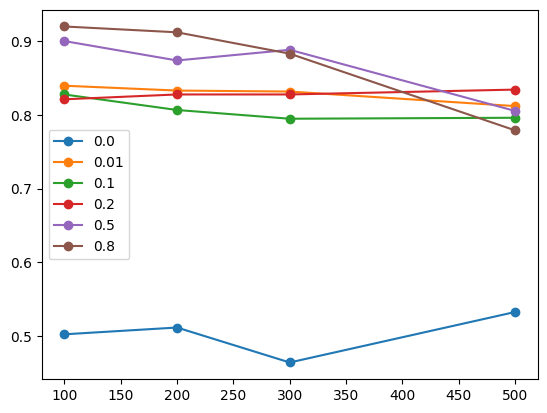

In [ ]:
import matplotlib.pyplot as plt

plt.figure()

for drop_rate in drop_rates:

    accuracy = df_projected[(df_projected['drop_rate'] == drop_rate)]['Test Accuracy']
    plt.plot(epochs_gnn_all, accuracy,'-o',  label = str(drop_rate))
plt.legend()
plt.show()

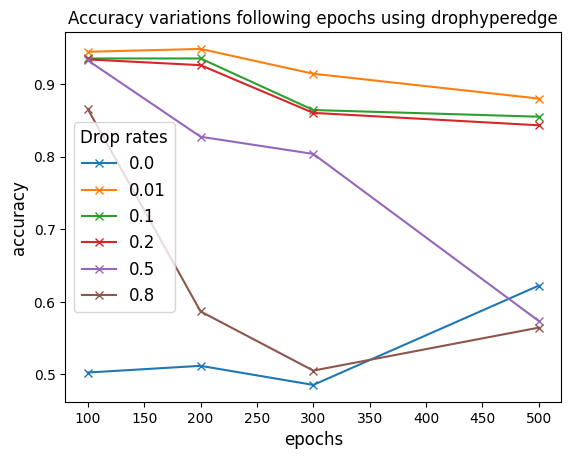

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

publisher = 'OYC'
drop_method = 'drophyperedge' #dropedge, dropnode or drophyperedge
parameter = 'epochs' #smoothing or epochs
drop_rates = [0.0, 0.01, 0.1, 0.2, 0.5, 0.8]
if drop_method == 'dropnode' or drop_method == 'dropedge':
    lambda_smoothing_all = [0.01, 0.1, 0.5, 0.8]
else:
    lambda_smoothing_all = [0.0, 0.01, 0.1, 0.2, 0.5, 0.8]
epochs_gnn_all = [100, 200, 300, 500]

df_results = pd.read_csv(f'./Output/{parameter}/results_{publisher}_{drop_method}.csv')
df_projected = df_results.drop(columns=['CV step', 'MLP Architecture']).groupby(['drop_method', 'Epochs GNN', 'Epochs Classifier', 'Learning rate', 'Smoothing', 'drop_rate'], as_index=False).mean()

for drop_rate in drop_rates:
    accuracy = df_projected[(df_projected['drop_rate'] == drop_rate)]['Test Accuracy']
    if parameter == 'epochs':
        plt.plot(epochs_gnn_all, accuracy,'-x',  label = str(drop_rate))
    elif parameter == 'smoothing':
        plt.plot(lambda_smoothing_all, accuracy,'-x',  label = str(drop_rate))

plt.ylabel("accuracy", size = 12)
plt.xlabel(parameter, size = 12)
plt.title(f"Accuracy variations following {parameter} using {drop_method}")

plt.legend(prop={'size': 12}, title="Drop rates", title_fontsize=12)
plt.savefig(f'./Output/figures/{publisher}_{drop_method}_{parameter}.png')

plt.show()

In [ ]:
top_index = df_projected.sort_values(by = ['Test Accuracy'] ,ascending=False).index[0]
df_projected.sort_values(by = ['Test Accuracy'] ,ascending=False).head()


,drop_method,Epochs GNN,Epochs Classifier,Learning rate,Smoothing,drop_rate,Test Accuracy,Test Precision
7,drophyperedge,200,100,0.001,0.1,0.01,0.948684,0.926841
1,drophyperedge,100,100,0.001,0.1,0.01,0.944737,0.916455
2,drophyperedge,100,100,0.001,0.1,0.10,0.935526,0.912402
8,drophyperedge,200,100,0.001,0.1,0.10,0.935526,0.911375
3,drophyperedge,100,100,0.001,0.1,0.20,0.934211,0.900625


In [79]:
mean_accuracy = int(round(df_results.iloc[top_index*5:(top_index+1)*5]['Test Accuracy'].values.mean(), 2) * 100)
std = int(round(df_results.iloc[top_index*5:(top_index+1)*5]['Test Accuracy'].values.std(), 2) * 100)
print(f'{mean_accuracy}($\pm${std})')

95($\pm$3)


In [101]:
raw_index = df_projected[df_projected['drop_rate'] == 0.0].sort_values(by = ['Test Accuracy'] ,ascending=False).index[0]
mean_accuracy = int(round(df_results.iloc[raw_index*5:(raw_index+1)*5]['Test Accuracy'].values.mean(), 2) * 100)
std = int(round(df_results.iloc[raw_index*5:(raw_index+1)*5]['Test Accuracy'].values.std(), 2) * 100)
print(f'{mean_accuracy}($\pm${std})')

81($\pm$5)
